In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold



# 1. Create useful functions

In [2]:
def after(text, string):
    # Find and validate first part.
    pos_str = text.rfind(string)
    if pos_str == -1: return ""
    # Returns chars after the found string.
    adjusted_pos_str = pos_str + len(string)
    if adjusted_pos_str >= len(text): return ""
    return text[adjusted_pos_str:]

def import_data(init_path, years):
    total_data=[]
    errors =[]
    for year in years:
        try:
            path = init_path+year+'.csv'
            data = pd.read_csv(path)
            total_data.append(data)
        except Exception as err:
            errors.append(err)
            bound = int(after(str(err), 'Expected')[1:3])
            path = init_path+year+'.csv'
            data = pd.read_csv(path, usecols=[i for i in range(bound)], encoding = 'unicode_escape')
            total_data.append(data)
            
    for i in range(len(total_data)):
        total_data[i] = delete_nan_column(total_data[i], 100)
                
    return total_data

def delete_nan_column(data, max_number_of_nas):
    data = data.loc[:, (data.isnull().sum(axis=0) <= max_number_of_nas)]
    return data

def merge_list(data):
    df = pd.merge(data[0], data[1], 'outer')
    for i in range(2, len(data)):
        df = pd.merge(df, data[i], 'outer')
    return df

def choose_team(data, team, date):
    """
    Output: returns all the data of a certain team available at time t-1 to predict a game a time t.
    """
    df = data.copy()
    return df.loc[((df['date'] < date) & (df['HomeTeam'] == team)) | (df['date'] < date) & (df['AwayTeam'] == team)] 

def choose_hometeam(data, team, date):
    df = data.copy()
    return df.loc[((df['date'] < date) & (df['HomeTeam'] == team))]

def choose_awayteam(data, team, date):
    df = data.copy()
    return df.loc[((df['date'] < date) & (df['AwayTeam'] == team))]


def last_results(team, game): 
    
    w_bonus = 1 #+1 for a Win
    d_bonus = 0 #0 for a Draw
    l_malus = - w_bonus #-1 for a Loss
    
    if game['HomeTeam'] == team:
        if game['FTR'] == 1:
            global_perf = w_bonus
        elif game['FTR'] == 2:
            global_perf = l_malus
        else:
            global_perf = d_bonus
        
    if game['AwayTeam'] == team:
        if game['FTR'] == 2:
            global_perf = w_bonus
        elif game['FTR'] == 1:
            global_perf = l_malus
        else:
            global_perf = d_bonus

    return global_perf

def EWMA(data, team, date, feature, gamma):
    
    subdata = choose_team(data, team, date) #all data available at t-1 to use to predict outcome at date t
        
    perfs=[]
    for i in range(len(subdata)):
        previous_game = subdata.iloc[i] #compute performance for all games before game at date t
        if feature == 'FTRH' or feature == 'FTRA':
            perfs.append(last_results(team, previous_game))
        else:
            perfs.append(previous_game[feature]) #stores performances of all games that happened until t-1
    
    #gamma = 0.01
    n = []
    d = []
    perf = [i for i in reversed(perfs)] #Now, perform an EWMA. To do so, we need to reverse the list, because
    # we go from the most recent observation (i.e. game) to the earliest one. 
    
    for i in range(len(perf)):
        #Apply EWMA formula
        coef = (1 - gamma)**i
        nominator = perf[i] * coef
        n.append(nominator)
        denominator = coef
        d.append(denominator)
    momentum = sum(n) / sum(d)
    
    return momentum

def clean_dataset(data):
    new_data = data.copy()
    from datetime import datetime
    
    new_data.dropna(subset=['Date'], inplace=True)
    
    dates = []
    for i in range(len(new_data)):
        date = new_data['Date'].iloc[i]
        try:   
            date = datetime.strptime(date, '%d/%m/%y')
        except:
            date = datetime.strptime(date, '%d/%m/%Y')   
        dates.append(date)
    dates = pd.DataFrame(dates, columns=['Date'])
    new_data['date'] = dates
    
    new_data = new_data[['date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HS',
                         'AS', 'HST', 'AST', 'HC', 'AC','HF', 'AF', 'B365H', 'B365D', 
                         'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 
                         'LBA', 'PSH', 'PSD','PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 
                         'VCA', 'PSCH', 'PSCD', 'PSCA', 'BbAv<2.5', 'BbAv>2.5']]
    
    new_data.dropna(inplace=True)
    new_data.reset_index(inplace=True)
    new_data = new_data.drop(['index'], axis=1)
    
    return new_data

def get_labels(data, label):
    Y = data[label]
    Y = np.array(Y)
    Y=Y.astype('int')
    
    return Y

def create_momentum_features(data, gamma, interval):
    
    k = interval[0]
    l = interval[1]
    
    data_bis = data.copy()
    
    game_features = ['FTRH', 'FTRA', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF']
    
    for feature in game_features:
        data_bis[feature + ' Momentum'] = np.nan
        
    home_features = ['FTRH', 'FTHG', 'HS', 'HC', 'HST', 'HF']
    away_features = ['FTRA', 'FTAG', 'AS', 'AC', 'AST', 'AF']

    
    for i in range(k, l):
        try:
            date = data_bis['date'].iloc[i]
            hometeam = data_bis['HomeTeam'].iloc[i]
            awayteam = data_bis['AwayTeam'].iloc[i]
            for feature in home_features:
                data_bis[feature + ' Momentum'].iloc[i] = EWMA(data_bis, hometeam, date, feature, gamma)
            for feature in away_features:
                data_bis[feature + ' Momentum'].iloc[i] = EWMA(data_bis, awayteam, date, feature, gamma)

        except:
            print(i)
           
    new_data  = data_bis.dropna()
    
    return new_data

def get_features(data, features, normalize=True):
    from sklearn.preprocessing import normalize
    X = np.array(data[features])
    if normalize:
        X = normalize(X)
    else:
        X = X
    
    return X

def convert_labels(data):
    
    df = data.copy()
    
    df.loc[df.FTR == "H", "FTR"] = 1 #Replace nominal target variables by numbers
    df.loc[df.FTR == "D", "FTR"] = 0
    df.loc[df.FTR == "A", "FTR"] = 2
    
    return df

def regression(dataset, algo, X, y1, y2, Kfold, train_set):
    import random
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import train_test_split
    
    test_accuracies=[]
    models_home=[]
    models_away=[]
    
    for n in random.sample(range(1,1000), Kfold):
        X_train1, X_test1, y_home_train, y_home_test = train_test_split(X, y1, train_size=train_set,random_state=n)
        X_train2, X_test2, y_away_train, y_away_test = train_test_split(X, y2, train_size=train_set,random_state=n)

        model_home = algo().fit(X_train1, y_home_train)
        models_home.append(model_home)
        model_away = algo().fit(X_train2, y_away_train)
        models_away.append(model_away)
        
    models = []
    for homeModel in models_home:
        for awayModel in models_away:
            
            y_home_hat = homeModel.predict(X).reshape((-1,1))
            y_home_hat = np.round(y_home_hat)
    
            y_away_hat = awayModel.predict(X).reshape((-1,1))
            y_away_hat = np.round(y_away_hat)
        
            home_coef = homeModel.coef_
            home_intercept = homeModel.intercept_
            w_home = np.insert(np.array(home_coef).reshape(-1,1), 0, home_intercept, axis=0)
        
            away_coef = awayModel.coef_
            away_intercept = awayModel.intercept_
            w_away = np.insert(np.array(away_coef).reshape(-1,1), 0, away_intercept, axis=0)
    
    
    
    
            predictions = []
            for i in range(len(y_home_hat)):
                if y_home_hat[i] > y_away_hat[i]:
                    predictions.append(1)
                elif y_home_hat[i] < y_away_hat[i]:
                    predictions.append(2)
                else:
                    predictions.append(0)
    
            predictions = np.array(predictions).reshape(-1,1)
            true_result = np.array(dataset['FTR']).astype('int').reshape(-1,1)
    
            accuracy = len(predictions[predictions==true_result])/len(predictions)
            models.extend(([accuracy], [w_home], [w_away]))
            
    models = np.array(models).reshape(-1, 3)
    idx = np.argmax(models[:,0])
    best_model = models[idx,:]
    
    return best_model

def optimal_regressor(algo, X, y, kfold, metrics):
    
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    kf = KFold(n_splits=kfold, shuffle=False)
    kf.split(X)
    
    models = []
    
    
    for train_index, test_index in kf.split(X):
        # Split train-test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if algo == LassoCV or algo == RidgeCV:
            model = algo(cv=kfold).fit(X_train, y_train.ravel())
        elif algo == LinearRegression:
            model = algo().fit(X_train, y_train.ravel())
        else:
            print('This algorithm is not available')
        
        y_pred = model.predict(X_test)
        
        if metrics == 'MSE':
            metric = mean_squared_error(y_test, y_pred, squared=True)
        elif metrics == 'RMSE':
            metric = mean_squared_error(y_test,y_pred, squared=False)
        elif metrics == 'MAE':
            metric = mean_absolute_error(y_test, y_pred)
        else:
            print('This metric is not available')
            
        error = metric
        if algo == LassoCV:
            algo_name = 'Lasso'
        elif algo == RidgeCV:
            algo_name = 'Ridge'
        elif algo == LinearRegression:
            algo_name = 'LinearRegression'
        else:
            print('This algorithm is not available')
            
        models.extend(([model], [algo_name], [error]))
        
    models = np.array(models).reshape(-1,3)
    idx = np.argmin(models[:, 1])
    opt_model = models[idx,:]
        
    return opt_model

def get_models(dataset, total_features, label, metrics, algos, gammas, k):
    from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, SGDRegressor
    #home_features = ['FTHG', 'HS', 'HC', 'HST', 'HF']
    #away_features = ['FTAG', 'AS', 'AC', 'AST', 'AF']
    #game_features = home_features + away_features
    #total_features = game_features + odds_features + momentum_features


    models = []

    for gamma in gammas:
        data_bis = dataset.copy()
        

        for feature in game_features:
            data_bis[feature + ' Momentum'] = np.nan
    
        home_teams = list(data_bis['HomeTeam'].unique())
        away_teams = list(data_bis['AwayTeam'].unique())
        max_date = max(data_bis['date'])

        for home_feature in home_features:
            for home_team in home_teams:
                column = choose_hometeam(data_bis, home_team, max_date)[home_feature].ewm(alpha=gamma, min_periods=k).mean().shift(1, axis=0)
                data_bis.loc[data_bis.HomeTeam == home_team, home_feature + " Momentum"] = column

        for away_feature in away_features:
            for away_team in away_teams:
                column = choose_awayteam(data_bis, away_team, max_date)[away_feature].ewm(alpha=gamma, min_periods=k).mean().shift(1, axis=0)
                data_bis.loc[data_bis.AwayTeam == away_team, away_feature + " Momentum"] = column

        data_prov = data_bis.dropna()
        
        X = get_features(data_prov, total_features, normalize=True)
        y = get_labels(data_prov, label)
        y = y.reshape(-1,1)

        for metric in metrics:
            for algo in algos:
                model, algo_name, min_error = optimal_regressor(algo, X, y, kfold=10, metrics=metric)
                models.extend(([algo_name], [model], [metric], [min_error], [gamma], [k]))
                #print('Alpha: ' + str(alpha), 'k: ' + str(k), 'Algo: ' + algo_name, 'Metrics: ' + metrics, 'Min_error: ' + str(min_error))
    models = np.array(models).reshape((-1, 6))
    
    return models

def plot_error_gamma(models, metric, k):
    import matplotlib.pyplot as plt
    models_1 = models[models[:,2] == metric]
    metric_ols = models_1[models_1[:,0] == 'LinearRegression']
    metric_ridge = models_1[models_1[:,0] == 'Ridge']
    metric_lasso = models_1[models_1[:,0] == 'Lasso']
    metric_1 = metric_ols[:,3]
    metric_2 = metric_ridge[:,3]
    metric_3 = metric_lasso[:,3]
    alpha = metric_ols[:,4]
    
    plt.figure(figsize=(12,8)) 
    plt.plot(alpha, metric_1, 'r') # plotting t, a separately 
    plt.plot(alpha, metric_2, 'b') # plotting t, b separately 
    plt.plot(alpha, metric_3, 'g') # plotting t, c separately 
    plt.legend(['Linear Regression', 'Ridge Regression', 'Lasso Regression'])
    plt.ylabel(metric)
    plt.xlabel('Gamma')
    plt.title(metric + ' as a function of EWMA exponential decay parameter gamma, k = ' + str(k))
    plt.savefig(metric + '_error' + '_k=' + str(k) + '.png')
    plt.show()

def predict_label(data, model, X, label):
    y_hat = model[0].predict(X)
    data_bis = data.copy()
    str_ = 'Predicted ' + label
    data_bis[str_] = y_hat
    
    return data_bis[['date', 'HomeTeam', 'AwayTeam', label, str_, 'BbAv>2.5', 'BbAv<2.5']]

def momentum_transformation(dataset, features, gamma, k):
    
    data_bis = dataset.copy()
    home_features = ['FTHG', 'HS', 'HC', 'HST', 'HF']
    away_features = ['FTAG', 'AS', 'AC', 'AST', 'AF']
    for feature in features:
        data_bis[feature + ' Momentum'] = np.nan
    
    home_teams = list(data_bis['HomeTeam'].unique())
    away_teams = list(data_bis['AwayTeam'].unique())
    max_date = max(data_bis['date'])

    for home_feature in home_features:
        for home_team in home_teams:
            column = choose_hometeam(data_bis, home_team, max_date)[home_feature].ewm(alpha=gamma, min_periods=k).mean().shift(1, axis=0)
            data_bis.loc[data_bis.HomeTeam == home_team, home_feature + " Momentum"] = column

    for away_feature in away_features:
        for away_team in away_teams:
            column = choose_awayteam(data_bis, away_team, max_date)[away_feature].ewm(alpha=gamma, min_periods=k).mean().shift(1, axis=0)
            data_bis.loc[data_bis.AwayTeam == away_team, away_feature + " Momentum"] = column

    data_bis.dropna(inplace=True)
    
    return data_bis


def value_bet_opportunity(odd1, odd2, delta):
    if 1/odd1 + 1/odd2 - 1 < delta:
        return 1
    else:
        return 0
    
def count_value_bets(data, bet1, bet2, delta):
    value_bets = []
    
    for i in range(len(data)):
        odd1 = opt_data[bet1].iloc[i]
        odd2 = opt_data[bet2].iloc[i]
        value_bet = value_bet_opportunity(odd1, odd2, delta)
        value_bets.append(value_bet)
        
    return np.sum(value_bets)

def value_bet_strategy(data_test, bet1, bet2, delta, strategy, initial_investment):
    
    import matplotlib.pyplot as plt
    
    #bet1, bet2 = ['BbAv>2.5', 'BbAv<2.5']
    #delta = 0.09
    plt.rcParams['figure.figsize']=(8,4)
    plt.style.use('ggplot')
    
    gains=[0]
    bankroll = len(data_test)
    pf = [bankroll]
    initial_investment = bankroll
    returns=[]
    mises=[]

    value_bets = []
    for i in range(len(data_test)):
        odd1 = data_test[bet1].iloc[i]
        odd2 = data_test[bet2].iloc[i]
        value_bet = value_bet_opportunity(odd1, odd2, delta)
        value_bets.append(value_bet)
        if value_bet == 1:
            mise = 1
        else:
            mise = 0
        money = 0.01 * bankroll * mise
        
        mises.append(mise)
        predicted_goals = data_test['Predicted FTTG'].iloc[i]
        actual_goals = data_test['FTTG'].iloc[i]
        
        if strategy == 'Active':
            
            if predicted_goals > 2.5 and actual_goals > 2.5:
                gain = mise * (odd1 - 1)
            elif predicted_goals < 2.5 and actual_goals < 2.5:
                gain = money * (odd2 - 1)
            else:
                gain = - money
        
        elif strategy == 'Passive':
            
            bet = np.argmin(data_test[[bet1, bet2]].iloc[i])
            if bet == 0 and actual_goals > 2.5:
                gain = money * (odd1 -1)
            elif bet == 1 and actual_goals < 2.5:
                gain = money * (odd2 - 1)
            else:
                gain = -money
        
        bankroll += gain
        pf.append(bankroll)
        rendement = (bankroll - initial_investment)/initial_investment
        returns.append(rendement)   
        gains.append(gain)
        
    gains = pd.DataFrame(gains, columns=['Gain per bet'])
    returns = pd.DataFrame(returns, columns=['Bets returns'])
    pf = pd.DataFrame(pf, columns=['Portfolio evolution'])
    
    
    returns.plot()
    plt.xlabel('Number of Bets')
    plt.ylabel('Cumulated Return')
    plt.title('Cumulated Return for ' + str(strategy) + ' strategy, delta = ' + str(delta))
        
    total_profit = np.sum(gains)
    portfolio_evolution = gains
    
    number_bets = np.sum(value_bets)
    capital_invested = np.sum(mises)
    roi = (total_profit - capital_invested) / capital_invested
    mean_return = np.mean(gains)
    risk = np.std(gains)
    
    return returns, mises, number_bets

def value_bet_return(data_test, bet1, bet2, delta, strategy, initial_investment, risk_aversion):
    
    #bet1, bet2 = ['BbAv>2.5', 'BbAv<2.5']
    #delta = 0.0525
    
    gains = []
    value_bets = []
    investment = initial_investment
    bankroll = [investment]
    returns = []
    for i in range(len(data_test)):
        
        odd1, odd2 = [data_test[bet1].iloc[i], data_test[bet2].iloc[i]]
        
        alpha = 1/odd1 + 1/odd2 - 1
        
        if alpha < delta:
            value_bets.append(1)
            #mise = 0.07 * investment
            
            if strategy == 'Active':
                
                if data_test['Predicted FTTG'].iloc[i] > 2.5 and data_test['FTTG'].iloc[i] > 2.5:
                    w = risk_aversion / (alpha*odd1)
                    mise = w * investment
                    gain = mise * (odd1 - 1)
                elif data_test['Predicted FTTG'].iloc[i] < 2.5 and data_test['FTTG'].iloc[i] < 2.5:
                    w = risk_aversion / (alpha*odd2)
                    mise = w * investment
                    gain = mise * (odd2 - 1)
                elif data_test['Predicted FTTG'].iloc[i] > 2.5 and data_test['FTTG'].iloc[i] < 2.5:
                    w = risk_aversion / (alpha*odd1)
                    gain = - w * investment
                elif data_test['Predicted FTTG'].iloc[i] < 2.5 and data_test['FTTG'].iloc[i] > 2.5:
                    w = risk_aversion / (alpha*odd2)
                    gain = - w * investment
            else:
                odd1 = data_test[bet1].iloc[i]
                odd2 = data_test[bet2].iloc[i]
                odds = [odd1, odd2]
                idx = np.argmin(odds)
                if idx == 0 and  data_test['FTTG'].iloc[i] > 2.5:
                    w = risk_aversion / (alpha*odd1)
                    mise = w * investment
                    gain = mise * (odd1 - 1)
                elif idx == 1 and  data_test['FTTG'].iloc[i] < 2.5:
                    w = risk_aversion / (alpha*odd2)
                    mise = w * investment
                    gain = mise * (odd2 - 1)
                elif idx == 0 and data_test['FTTG'].iloc[i] < 2.5:
                    w = risk_aversion / (alpha*odd1)
                    gain = - w * investment
                elif idx == 1 and data_test['FTTG'].iloc[i] > 2.5:
                    w = risk_aversion / (alpha*odd2)
                    gain = - w * investment
        else:
            gain = 0
        investment+=gain
        bankroll.append(investment)
        rendement = (investment - initial_investment)/initial_investment
        returns.append(rendement)
        
  
        gains.append(gain)
    
    gains = np.array(gains)
    bets = gains[gains!=0]
    profit = bankroll[-1] - bankroll[0]
    roi = profit / bankroll[0]
                
            
    return np.mean(returns), np.std(returns), returns, len(bets), profit, roi

def optimal_model(model, metric):
    opt_model = model[model[:,2]==metric]
    idx = np.argmin(opt_model[:,3])
    optimal_model = opt_model[idx,:]
    algo_star = optimal_model[0]
    metric_star = optimal_model[3]
    gamma_star = optimal_model[4]
    return algo_star, gamma_star, metric_star

    

# 2. The Regression Problem

In [3]:
%%time
personnal_path = '/Users/allanbellahsene/Desktop/DATA_SCIENCE_PROJECT_ALLAN/'
common_path = 'data/LIGA/Liga_'
path = personnal_path + common_path
years = ['2010', '2011', '2012','2013', '2014', '2015', '2016', '2017', '2018', '2019']
new_data = import_data(init_path=path, years=years)
new_data=merge_list(new_data)
new_data = clean_dataset(new_data)
odds_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 
                 'LBA', 'PSH', 'PSD','PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA',
                'BbAv<2.5', 'BbAv>2.5']
momentum_features = ['FTHG Momentum', 'HS Momentum', 'HC Momentum', 'HST Momentum', 'HF Momentum',
                    'FTAG Momentum', 'AS Momentum', 'AC Momentum', 'AST Momentum', 'AF Momentum']
new_data['FTTG'] = new_data['FTHG'] + new_data['FTAG']

CPU times: user 1.5 s, sys: 62.8 ms, total: 1.56 s
Wall time: 2.17 s


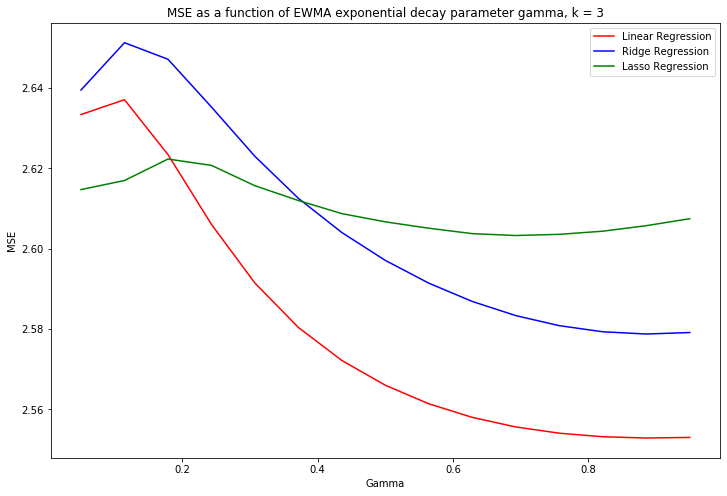

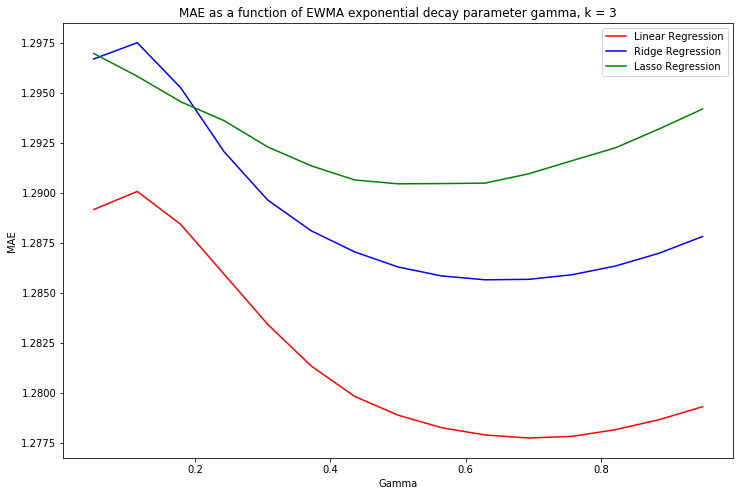

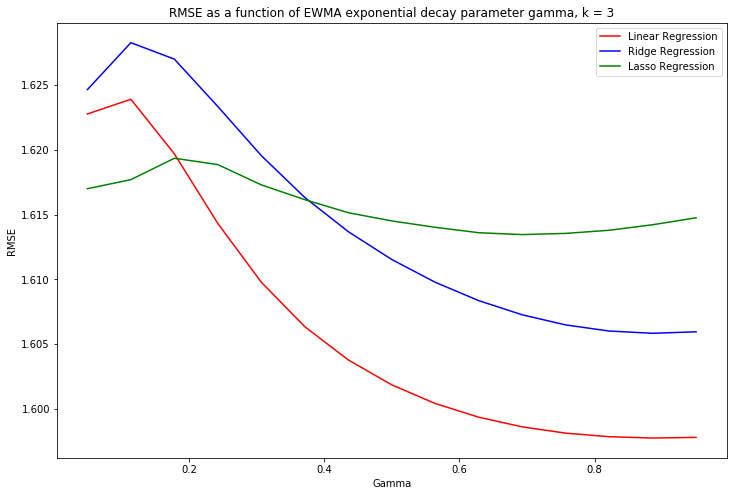

CPU times: user 7min 42s, sys: 10.6 s, total: 7min 53s
Wall time: 4min 36s


In [4]:
%%time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,5)
home_features = ['FTHG', 'HS', 'HC', 'HST', 'HF']
away_features = ['FTAG', 'AS', 'AC', 'AST', 'AF']
game_features = home_features + away_features
total_features = odds_features + momentum_features
label = 'FTTG'
algos = [LinearRegression, LassoCV, RidgeCV]
gammas = list(np.linspace(0.05, 0.95, 15))
metrics = ['MSE', 'MAE', 'RMSE']
k = 3
best_models = get_models(new_data, total_features, label, metrics, algos, gammas, k)   
for metric in metrics:
     plot_error_gamma(best_models, metric, k)

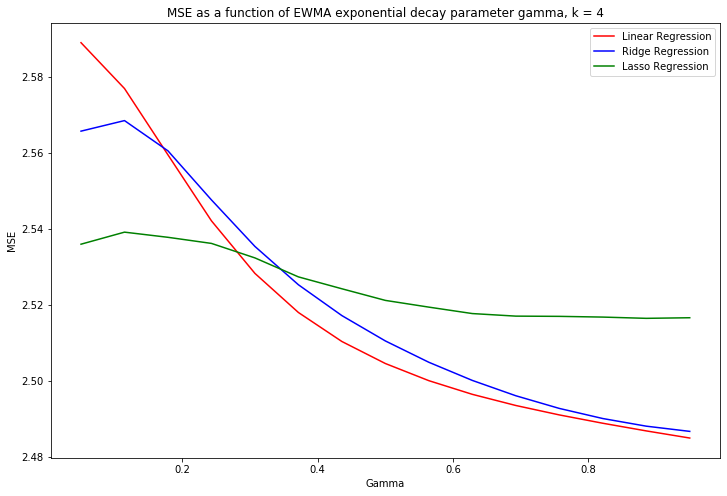

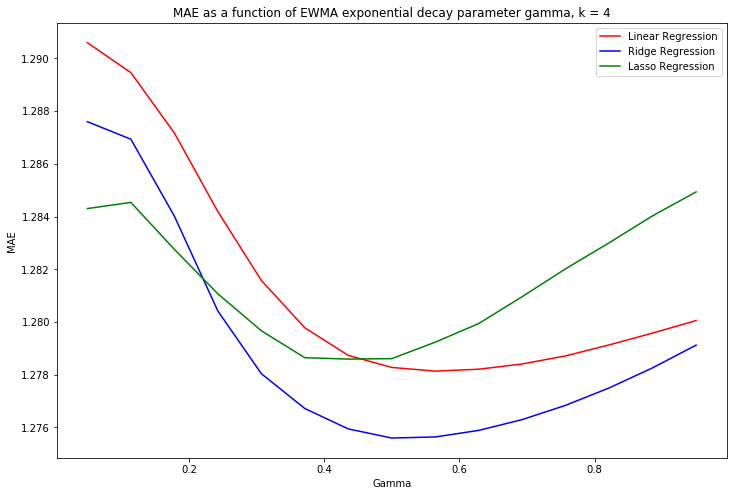

In [5]:
metrics = ['MSE', 'MAE']
k = 4
best_models = get_models(new_data, total_features, label, metrics, algos, gammas, k)   
for metric in metrics:
     plot_error_gamma(best_models, metric, k)

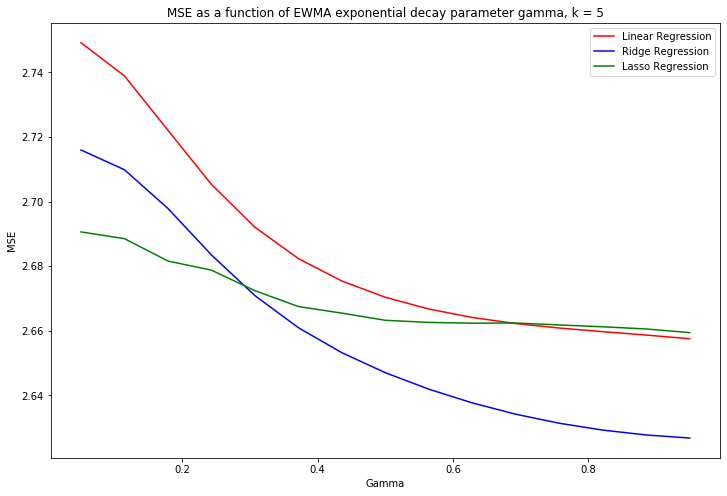

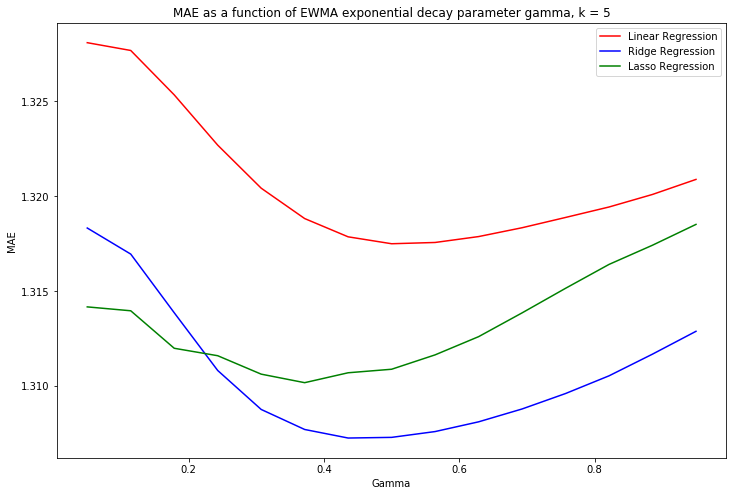

In [6]:
metrics = ['MSE', 'MAE']
k = 5
best_models = get_models(new_data, total_features, label, metrics, algos, gammas, k)   
for metric in metrics:
     plot_error_gamma(best_models, metric, k)

In [7]:
%%time
home_features = ['FTHG', 'HS', 'HC', 'HST', 'HF']
away_features = ['FTAG', 'AS', 'AC', 'AST', 'AF']
game_features = home_features + away_features
total_features = odds_features + momentum_features
label = 'FTTG'
algos = [LinearRegression, LassoCV, RidgeCV]
gammas = list(np.linspace(0.05, 0.95, 15))
metrics = ['MSE', 'MAE', 'RMSE']

CPU times: user 252 µs, sys: 38 µs, total: 290 µs
Wall time: 306 µs


In [8]:
for k in [1, 2, 3, 4, 5, 6]:
    best_models = get_models(new_data, total_features, label, metrics, algos, gammas, k)
    for metric in ['MSE', 'MAE', 'RMSE']:
        algo_star, gamma_star, metric_star = optimal_model(best_models, metric)
        print('Metric: ' + metric + ',k = ' + str(k), 'Algo star: ' + str(algo_star), ', Gamma star = '
             + str(gamma_star), 'min ' + metric + ': ' +  str(metric_star))
    

Metric: MSE,k = 1 Algo star: LinearRegression , Gamma star = 0.95 min MSE: 2.6711575352216794
Metric: MAE,k = 1 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min MAE: 1.3048182356987057
Metric: RMSE,k = 1 Algo star: LinearRegression , Gamma star = 0.95 min RMSE: 1.6343676254813908
Metric: MSE,k = 2 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min MSE: 2.5819805656973354
Metric: MAE,k = 2 Algo star: LinearRegression , Gamma star = 0.8214285714285714 min MAE: 1.2871077893025005
Metric: RMSE,k = 2 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min RMSE: 1.6068542453182664
Metric: MSE,k = 3 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min MSE: 2.5528272948397785
Metric: MAE,k = 3 Algo star: LinearRegression , Gamma star = 0.6928571428571428 min MAE: 1.2777514374133978
Metric: RMSE,k = 3 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min RMSE: 1.5977569573748627
Metric: MSE,k = 4 Algo star: LinearRegression , Ga

In [9]:
for k in [2, 3, 4]:
    best_models = get_models(new_data, total_features, label, metrics, algos, gammas, k)
    for metric in ['MSE', 'MAE', 'RMSE']:
        algo_star, gamma_star, metric_star = optimal_model(best_models, metric)
        print('Metric: ' + metric + ',k = ' + str(k), 'Algo star: ' + str(algo_star), ', Gamma star = '
             + str(gamma_star), 'min ' + metric + ': ' +  str(metric_star))

Metric: MSE,k = 2 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min MSE: 2.5819805656973354
Metric: MAE,k = 2 Algo star: LinearRegression , Gamma star = 0.8214285714285714 min MAE: 1.2871077893025005
Metric: RMSE,k = 2 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min RMSE: 1.6068542453182664
Metric: MSE,k = 3 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min MSE: 2.5528272948397785
Metric: MAE,k = 3 Algo star: LinearRegression , Gamma star = 0.6928571428571428 min MAE: 1.2777514374133978
Metric: RMSE,k = 3 Algo star: LinearRegression , Gamma star = 0.8857142857142857 min RMSE: 1.5977569573748627
Metric: MSE,k = 4 Algo star: LinearRegression , Gamma star = 0.95 min MSE: 2.484952635443036
Metric: MAE,k = 4 Algo star: Ridge , Gamma star = 0.49999999999999994 min MAE: 1.2755996705692125
Metric: RMSE,k = 4 Algo star: LinearRegression , Gamma star = 0.95 min RMSE: 1.5763732538466375


In [10]:
gamma_star = 0.95 #0.5
k_star = 3 #3
opt_data = momentum_transformation(new_data, game_features, gamma=gamma_star, k=k_star)
X = get_features(opt_data, features=total_features)
y = get_labels(opt_data, 'FTTG')
algo_star = LinearRegression
opt_model = optimal_regressor(algo_star, X, y, kfold=10, metrics='RMSE')

# 3. Train the value bet Strategy

$ w^* = \frac{a}{\alpha * odd} $, where the higher a, the more agressive the strategy.

In [11]:
train_data = predict_label(opt_data,opt_model, X, 'FTTG')

CPU times: user 30.3 s, sys: 124 ms, total: 30.4 s
Wall time: 30.5 s


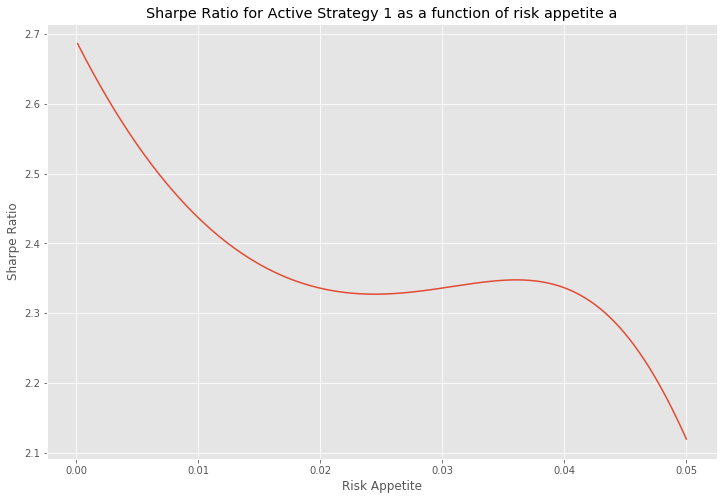

In [12]:
%%time
import matplotlib.pyplot as plt
bet1, bet2 = ['BbAv>2.5', 'BbAv<2.5']
strategy = 'Active'
initial_investment = 1000
ratios = []
delta = 0.05
#for delta in list(np.linspace(0.04, 0.05, 50)):
for a in list(np.linspace(0.0001, 0.05, 500)):
    #[0.001, 0.01, 0.1, 0.5, 1, 2, 3, 10]:
    mean_return, volatility, returns, n_bets, profit, roi = value_bet_return(train_data, bet1, bet2, delta,
                                                                    strategy, initial_investment, risk_aversion=a)
    sharpe_ratio = mean_return/volatility
    ratios.extend(([sharpe_ratio], [roi], [delta], [a], [profit], [mean_return], [volatility]))
        #print('Strategy: ' + str(strategy), ', Risk aversion: ' + str(a), ' delta: ' + str(delta), ' n_bets: ' + str(n_bets), ' expected return per bet: ' + str(mean_return), ' Vol.: ' + str(volatility))
ratios = np.array(ratios).reshape(-1,7)
ratios = pd.DataFrame(data=ratios, columns=['Sharpe Ratio', 'ROI', 'Delta', 'Risk Aversion', 'Profit', 'Mean Return', 'Volatility'])
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')
plt.plot(ratios['Risk Aversion'], ratios['Sharpe Ratio'])
plt.xlabel('Risk Appetite')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for Active Strategy 1 as a function of risk appetite a')
plt.savefig('SharpeRatioActiveStrategy1.png')

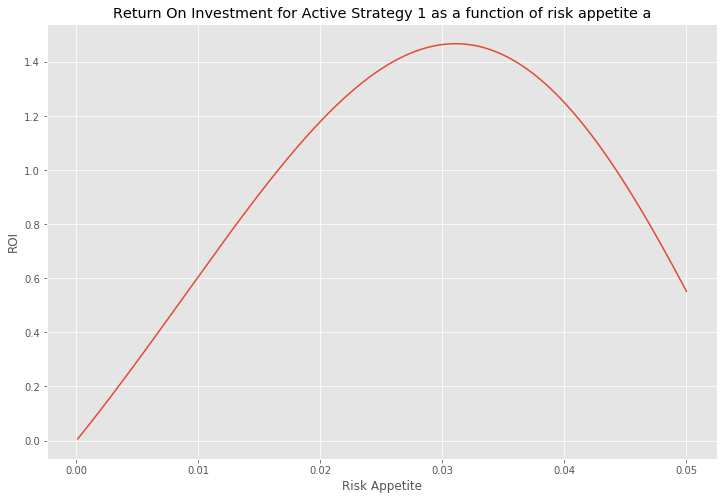

In [13]:
plt.plot(ratios['Risk Aversion'], ratios['ROI'])
plt.xlabel('Risk Appetite')
plt.ylabel('ROI')
plt.title('Return On Investment for Active Strategy 1 as a function of risk appetite a')
plt.savefig('ROIActiveStrategy1.png')

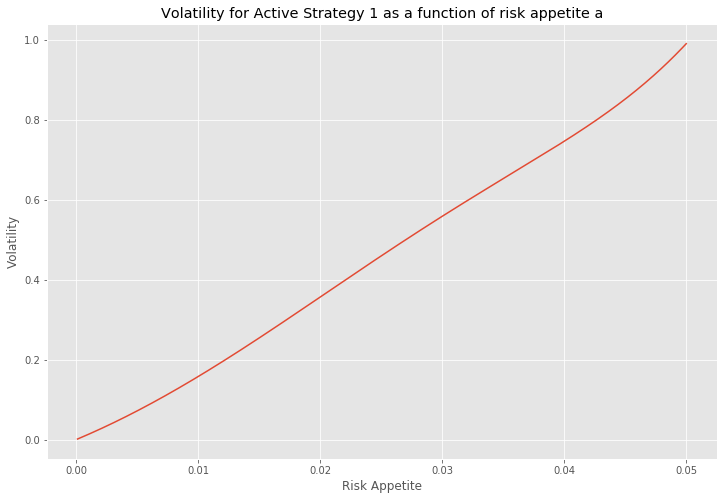

In [14]:
plt.plot(ratios['Risk Aversion'], ratios['Volatility'])
plt.xlabel('Risk Appetite')
plt.ylabel('Volatility')
plt.title('Volatility for Active Strategy 1 as a function of risk appetite a')
plt.savefig('VolActiveStrategy1.png')

In [15]:
ratios = ratios.loc[ratios['ROI']>0.05]
idx = np.argmax(ratios['Sharpe Ratio'])
best_ratio = pd.DataFrame(ratios.iloc[idx])
delta_star = 0.05
a_star = float(best_ratio.iloc[3])
best_ratio

,8
Sharpe Ratio,2.659494
ROI,0.050808
Delta,0.050000
Risk Aversion,0.000900
Profit,50.808123
Mean Return,0.031359
Volatility,0.011791


Text(0.5, 1.0, 'Cumulated ROI as a function of number of games for Passive strategy on train data, delta=0.05, a= 0.0009000000000000001')

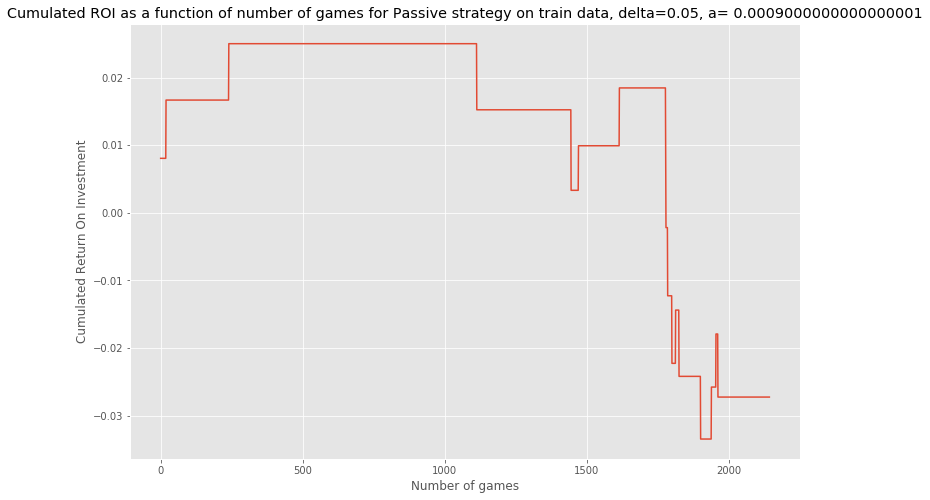

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

    
mean_return, volatility, returns, n_bets, profit, roi = value_bet_return(train_data, bet1, bet2, 
                                                                         delta=delta_star, strategy='Passive', 
                                                                         initial_investment=1000, risk_aversion = a_star)
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')
plt.plot(returns)
plt.xlabel('Number of games')
plt.ylabel('Cumulated Return On Investment')
plt.title('Cumulated ROI as a function of number of games for Passive strategy on train data, delta=' + str(delta_star) + ', a= ' + str(a_star))

Text(0.5, 1.0, 'Cumulated ROI as a function of number of games for Active strategy on train data, delta=0.05, a= 0.0009000000000000001')

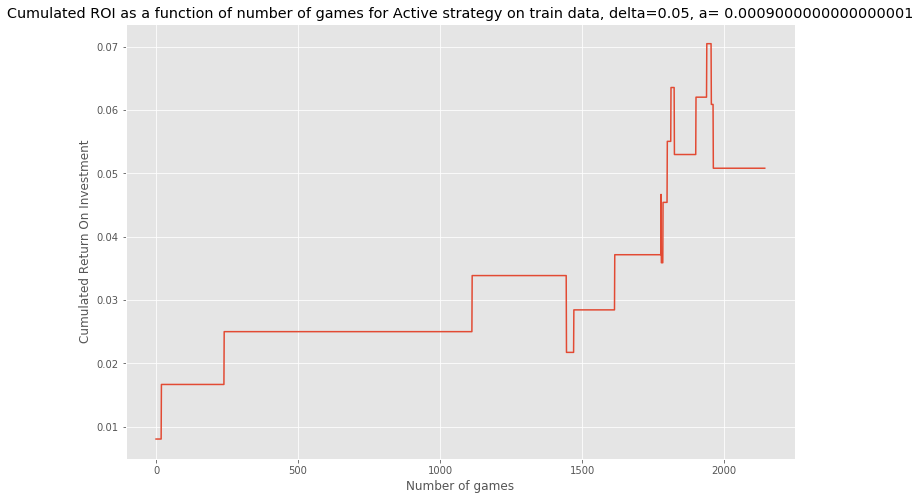

In [17]:
mean_return, volatility, returns, n_bets, profit, roi = value_bet_return(train_data, bet1, bet2, 
                                                                         delta=delta_star, strategy='Active', 
                                                                         initial_investment=1000, risk_aversion = a_star)
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')
plt.plot(returns)
plt.xlabel('Number of games')
plt.ylabel('Cumulated Return On Investment')
plt.title('Cumulated ROI as a function of number of games for Active strategy on train data, delta=' + str(delta_star) + ', a= ' + str(a_star))
#plt.title('Cumulated ROI as a function of number of games for Active strategy on train data, delta=0.049947, a=0.525517')

# 4. Test the value bet Strategy

In [18]:
%%time
personnal_path = '/Users/allanbellahsene/Desktop/'
common_path = 'DATA_SCIENCE_PROJECT_ALLAN/data/PREMIER_LEAGUE/PL_'
path = personnal_path + common_path
years = ['2016', '2017', '2018', '2019']
test_data = import_data(init_path=path, years=years)
test_data=merge_list(test_data)
test_data = clean_dataset(test_data)
odds_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 
                 'LBA', 'PSH', 'PSD','PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA',
                'BbAv<2.5', 'BbAv>2.5']
momentum_features = ['FTHG Momentum', 'HS Momentum', 'HC Momentum', 'HST Momentum', 'HF Momentum',
                     'FTAG Momentum', 'AS Momentum', 'AC Momentum', 'AST Momentum', 'AF Momentum']
test_data['FTTG'] = test_data['FTHG'] + test_data['FTAG']

CPU times: user 370 ms, sys: 11 ms, total: 381 ms
Wall time: 389 ms


In [19]:
test_data = momentum_transformation(test_data, game_features, gamma=gamma_star, k=k_star)
X_test = get_features(test_data, features=total_features)
y_test = get_labels(test_data, 'FTTG')

In [20]:
data_test = predict_label(test_data, opt_model, X_test, 'FTTG')

In [21]:
bet1, bet2 = ['BbAv>2.5', 'BbAv<2.5']
strategy = 'Active'
initial_investment = 1000
mean_return, volatility, returns1, n_bets, profit, roi = value_bet_return(data_test, bet1, bet2, 
                                                                         delta=delta_star, strategy=strategy, 
                                                                         initial_investment=1000, 
                                                                         risk_aversion=a_star)
mean_return, volatility, returns2, n_bets, profit, roi = value_bet_return(data_test, bet1, bet2, 
                                                                         delta=delta_star, strategy='Passive', 
                                                                         initial_investment=1000, 
                                                                         risk_aversion=a_star)

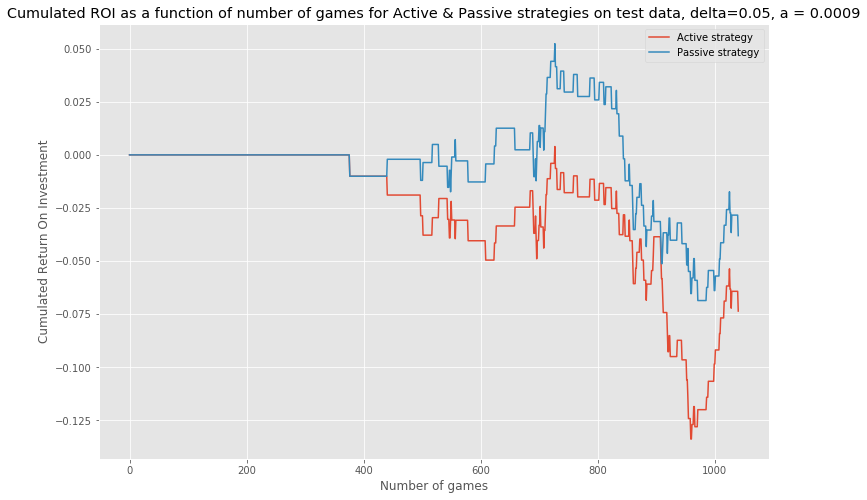

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')
n_bets = np.linspace(0, len(returns1), len(returns1))
plt.plot(n_bets, returns1)
plt.plot(n_bets, returns2)
plt.xlabel('Number of games')
plt.ylabel('Cumulated Return On Investment')
plt.legend(['Active strategy', 'Passive strategy'])
plt.title('Cumulated ROI as a function of number of games for Active & Passive strategies on test data, delta=' + str(delta_star)+ ', a = 0.0009')
plt.savefig('Active&PassiveStrategy.png')